In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

from datetime import datetime, date
import yfinance as yf
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [5]:
'''getting stock history obj'''
tickerSymbol = 'MSFT'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history( start='2016-1-2', end='2019-5-31')
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-04,49.82,50.26,48.97,50.26,53778000,0.0,0
2016-01-05,50.38,50.80,50.02,50.49,34079700,0.0,0
2016-01-06,49.82,49.89,49.19,49.57,39518900,0.0,0
2016-01-07,48.33,49.06,47.76,47.85,56564900,0.0,0
2016-01-08,48.03,48.86,47.83,47.99,48754000,0.0,0
...,...,...,...,...,...,...,...
2019-05-23,124.67,124.75,123.22,124.65,23603800,0.0,0
2019-05-24,125.37,125.87,124.44,124.71,14123400,0.0,0
2019-05-28,125.44,126.44,124.52,124.63,23128400,0.0,0


In [6]:
### '''getting data from dataframe'''
dateIndexFrame=tickerDf.index

'''turning all values to list'''
valuesList = tickerDf.values.tolist()  

'''getting only prices (first 4 elements) / volumes (5th) for normaliztion'''
pricesList = [row[0:4] for row in valuesList]
volumeList = [[row[4]] for row in valuesList]

'''making scalers, they're separate to later unscale'''
priceScaler = MinMaxScaler(feature_range=(0, 1)) 
volumeScaler = MinMaxScaler(feature_range=(0, 1)) 

'''normalizing'''
priceListNormalized = priceScaler.fit_transform(pricesList)
volumeListNormalized = volumeScaler.fit_transform(volumeList)

'''recollecting prices/volume in one list '''
valuesListNormalized = []

'''valuesListNormalized - dataframe normalized'''
for idx, pricesRow in enumerate(priceListNormalized):
    valuesRow = pricesRow.tolist()
    valuesRow.append(volumeListNormalized[idx].tolist()[0])
    valuesListNormalized+=[valuesRow]




In [7]:


'''ohlcvValue: Index 0-Open, 1-High, 2-Low, 3-Close, 4-Volume'''
def getDataTarget(ohlcvValue):
    '''predicting based on numDaysForPrediction, predicting average for next numDaysPredicting'''
    numDaysForPrediction = 20
    numDaysPredicting = 5
    '''targetWeek can be used for simulating sell later on'''
    targetWeek = []
    
    forPredictionFullLocal = []
    targetFullLocal = []
        
    for idx in range(len(valuesListNormalized)-(numDaysForPrediction)-(numDaysPredicting)):
        #print(idx)
        '''making a list of numDaysForPrediction(20) from valuesListNormalized [1,2,3,..., 20] [2,3,4,...,21] ...'''
        forPredictionSingle = valuesListNormalized[idx:idx+numDaysForPrediction]
        forPredictionFullLocal += [forPredictionSingle]

        '''make a list of targets, average of next numDaysPredicting, for 0-20, getting 20-25'''
        targetRow = valuesListNormalized[idx+numDaysForPrediction:idx+numDaysForPrediction+numDaysPredicting]
        targetTotal = 0
        '''saving target week for later'''
        targetWeek+=[targetRow]
        
        for day in targetRow:
            targetTotal += day[ohlcvValue] # Index 0-Open, 1-High, 2-Low, 3-Close, 4-Volume
        targetFullLocal +=  [targetTotal/numDaysPredicting]

    return forPredictionFullLocal, targetFullLocal, targetWeek




In [8]:
'''to numpy array and splitting to train and test datasets, x_train - y_train, x_test - y_test'''
forPredictionFull, targetFull, targetWeek = getDataTarget(1);

data = np.array(forPredictionFull, dtype=float)
target = np.array(targetFull,dtype=float)

randState=4
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=randState)
x_nouse, test_x_targetWeek, y_nouse, test_y_targetWeek = train_test_split(targetWeek, target, test_size=0.1, random_state=randState)

print (data.shape)
print (target.shape)
    
'''Setup model'''
model=Sequential()
'''layers'''
model.add(LSTM((128), batch_input_shape=(None, None, 5), return_sequences=True))
model.add(LSTM((64)))
model.add(Dense(1))


model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
print(model.summary())


(832, 20, 5)
(832,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         68608     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
'''training'''
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test))

Epoch 1/500
24/24 [==============================] - 2s 69ms/step - loss: 0.0743 - accuracy: 0.0000e+00 - val_loss: 0.0421 - val_accuracy: 0.0000e+00
Epoch 2/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0232 - accuracy: 0.0000e+00 - val_loss: 0.0201 - val_accuracy: 0.0000e+00
Epoch 3/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0175 - accuracy: 0.0000e+00 - val_loss: 0.0152 - val_accuracy: 0.0000e+00
Epoch 4/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0169 - accuracy: 0.0000e+00 - val_loss: 0.0137 - val_accuracy: 0.0000e+00
Epoch 5/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0166 - accuracy: 0.0000e+00 - val_loss: 0.0192 - val_accuracy: 0.0000e+00
Epoch 6/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0159 - accuracy: 0.0000e+00 - val_loss: 0.0174 - val_accuracy: 0.0000e+00
Epoch 7/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0165 - accuracy: 0.0000e

24/24 [==============================] - 1s 38ms/step - loss: 0.0116 - accuracy: 0.0000e+00 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 56/500
24/24 [==============================] - 1s 37ms/step - loss: 0.0122 - accuracy: 0.0000e+00 - val_loss: 0.0125 - val_accuracy: 0.0000e+00
Epoch 57/500
24/24 [==============================] - 1s 40ms/step - loss: 0.0115 - accuracy: 0.0000e+00 - val_loss: 0.0116 - val_accuracy: 0.0000e+00
Epoch 58/500
24/24 [==============================] - 1s 39ms/step - loss: 0.0120 - accuracy: 0.0000e+00 - val_loss: 0.0146 - val_accuracy: 0.0000e+00
Epoch 59/500
24/24 [==============================] - 1s 43ms/step - loss: 0.0131 - accuracy: 0.0000e+00 - val_loss: 0.0160 - val_accuracy: 0.0000e+00
Epoch 60/500
24/24 [==============================] - 1s 40ms/step - loss: 0.0139 - accuracy: 0.0000e+00 - val_loss: 0.0193 - val_accuracy: 0.0000e+00
Epoch 61/500
24/24 [==============================] - 1s 38ms/step - loss: 0.0149 - accuracy: 0.0000e+00 - 

24/24 [==============================] - 1s 33ms/step - loss: 0.0109 - accuracy: 0.0000e+00 - val_loss: 0.0112 - val_accuracy: 0.0000e+00
Epoch 110/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0118 - accuracy: 0.0000e+00 - val_loss: 0.0127 - val_accuracy: 0.0000e+00
Epoch 111/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 112/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 0.0117 - val_accuracy: 0.0000e+00
Epoch 113/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0121 - accuracy: 0.0000e+00 - val_loss: 0.0119 - val_accuracy: 0.0000e+00
Epoch 114/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0116 - accuracy: 0.0000e+00 - val_loss: 0.0132 - val_accuracy: 0.0000e+00
Epoch 115/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0115 - accuracy: 0.0000e

Epoch 163/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0114 - accuracy: 0.0000e+00 - val_loss: 0.0115 - val_accuracy: 0.0000e+00
Epoch 164/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - val_loss: 0.0112 - val_accuracy: 0.0000e+00
Epoch 165/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 166/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - val_loss: 0.0149 - val_accuracy: 0.0000e+00
Epoch 167/500
24/24 [==============================] - 1s 32ms/step - loss: 0.0131 - accuracy: 0.0000e+00 - val_loss: 0.0113 - val_accuracy: 0.0000e+00
Epoch 168/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0109 - accuracy: 0.0000e+00 - val_loss: 0.0124 - val_accuracy: 0.0000e+00
Epoch 169/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0104 - acc

Epoch 217/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0101 - accuracy: 0.0000e+00 - val_loss: 0.0123 - val_accuracy: 0.0000e+00
Epoch 218/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 0.0116 - val_accuracy: 0.0000e+00
Epoch 219/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0102 - accuracy: 0.0000e+00 - val_loss: 0.0109 - val_accuracy: 0.0000e+00
Epoch 220/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0101 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 0.0000e+00
Epoch 221/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0101 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_accuracy: 0.0000e+00
Epoch 222/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0098 - accuracy: 0.0000e+00 - val_loss: 0.0106 - val_accuracy: 0.0000e+00
Epoch 223/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0117 - acc

Epoch 271/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0095 - accuracy: 0.0000e+00 - val_loss: 0.0113 - val_accuracy: 0.0000e+00
Epoch 272/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0114 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 273/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0136 - accuracy: 0.0000e+00 - val_loss: 0.0103 - val_accuracy: 0.0000e+00
Epoch 274/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0122 - accuracy: 0.0000e+00 - val_loss: 0.0136 - val_accuracy: 0.0000e+00
Epoch 275/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0104 - accuracy: 0.0000e+00 - val_loss: 0.0120 - val_accuracy: 0.0000e+00
Epoch 276/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0096 - accuracy: 0.0000e+00 - val_loss: 0.0132 - val_accuracy: 0.0000e+00
Epoch 277/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0106 - acc

Epoch 325/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0096 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_accuracy: 0.0000e+00
Epoch 326/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0091 - accuracy: 0.0000e+00 - val_loss: 0.0108 - val_accuracy: 0.0000e+00
Epoch 327/500
24/24 [==============================] - 1s 32ms/step - loss: 0.0097 - accuracy: 0.0000e+00 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 328/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0096 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_accuracy: 0.0000e+00
Epoch 329/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0101 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_accuracy: 0.0000e+00
Epoch 330/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0100 - accuracy: 0.0000e+00 - val_loss: 0.0106 - val_accuracy: 0.0000e+00
Epoch 331/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0096 - acc

Epoch 379/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0100 - accuracy: 0.0000e+00 - val_loss: 0.0112 - val_accuracy: 0.0000e+00
Epoch 380/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0102 - accuracy: 0.0000e+00 - val_loss: 0.0126 - val_accuracy: 0.0000e+00
Epoch 381/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0100 - accuracy: 0.0000e+00 - val_loss: 0.0112 - val_accuracy: 0.0000e+00
Epoch 382/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0106 - val_accuracy: 0.0000e+00
Epoch 383/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0094 - accuracy: 0.0000e+00 - val_loss: 0.0112 - val_accuracy: 0.0000e+00
Epoch 384/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0100 - accuracy: 0.0000e+00 - val_loss: 0.0113 - val_accuracy: 0.0000e+00
Epoch 385/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0105 - acc

Epoch 433/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0109 - val_accuracy: 0.0000e+00
Epoch 434/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0092 - accuracy: 0.0000e+00 - val_loss: 0.0120 - val_accuracy: 0.0000e+00
Epoch 435/500
24/24 [==============================] - 1s 32ms/step - loss: 0.0093 - accuracy: 0.0000e+00 - val_loss: 0.0106 - val_accuracy: 0.0000e+00
Epoch 436/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0091 - accuracy: 0.0000e+00 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 437/500
24/24 [==============================] - 1s 34ms/step - loss: 0.0091 - accuracy: 0.0000e+00 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 438/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0086 - accuracy: 0.0000e+00 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 439/500
24/24 [==============================] - 1s 33ms/step - loss: 0.0088 - acc

Epoch 487/500
24/24 [==============================] - 1s 52ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - val_loss: 0.0109 - val_accuracy: 0.0000e+00
Epoch 488/500
24/24 [==============================] - 1s 39ms/step - loss: 0.0086 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 0.0000e+00
Epoch 489/500
24/24 [==============================] - 1s 44ms/step - loss: 0.0085 - accuracy: 0.0000e+00 - val_loss: 0.0134 - val_accuracy: 0.0000e+00
Epoch 490/500
24/24 [==============================] - 1s 35ms/step - loss: 0.0093 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_accuracy: 0.0000e+00
Epoch 491/500
24/24 [==============================] - 1s 49ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 492/500
24/24 [==============================] - 1s 37ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 493/500
24/24 [==============================] - 1s 56ms/step - loss: 0.0086 - acc

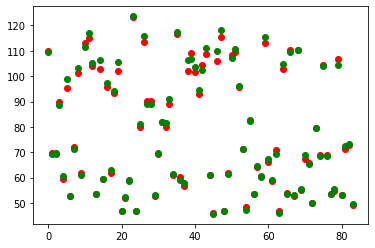

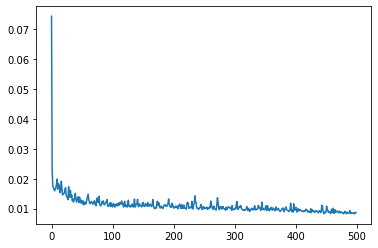

In [10]:
'''testing / predicitng'''
predictionNormalized = model.predict(x_test)

'''reshaping to 5 items in row, filling with 0s '''
predictionReshaped = [[row.tolist()[0],0,0,0] for row in predictionNormalized]
targetReshaped = [[row.tolist(),0,0,0] for row in y_test]

'''inversing trasnform for prediciton'''
predictionInversed = priceScaler.inverse_transform(predictionReshaped)
predictionInversed = [[firstElement[0]] for firstElement in predictionInversed]

'''inversing trasnform for target'''
targetInversed = priceScaler.inverse_transform(targetReshaped)
targetInversed = [[firstElement[0]] for firstElement in targetInversed]

'''prediciton / target scatter'''
plt.scatter(range(len(predictionInversed)), predictionInversed , c='r')
plt.scatter(range(len(targetInversed)), targetInversed, c='g')
plt.show()

'''loss graph'''
plt.plot(history.history['loss'])
plt.show()

In [11]:
def tradeSimulation():
    '''getting close list to simulate buying on close the day before prediction week'''
    x_testPrices = [row[-1][0:4] for row in x_test] #get last day before prediciton week, and strip volume from list
    x_testInversed = priceScaler.inverse_transform(x_testPrices) #inverse normalization
    x_testOnlyClose = [round(row[3],2) for row in x_testInversed] #get Close price of the day

    tooHighNum = 0
    tooLowNum = 0
    goodGuessNum = 0
    balanceTotal = 0
    balancePercTotal = 0
    
    realBalanceTotal = 0
    realBalancePercTotal = 0
    
    numTrades=0
    passiveTotal = 0
    
    for idx in range(len(x_testOnlyClose)):

        lastWeekClose = x_testOnlyClose[idx]
        weekPredictionAvg = round(predictionInversed[idx][0],2)
        weekActualAvg = round(targetInversed[idx][0],2)

        if weekPredictionAvg < weekActualAvg: tooLowNum+=1
        elif weekPredictionAvg > weekActualAvg: tooHighNum+=1
        else: goodGuessNum+=1
    
        '''calculating balance without ai interference'''   
        tradeTotal = round(weekActualAvg - lastWeekClose,2)
        passiveTotal+=tradeTotal
        
        '''only buying those bot liked'''
        if lastWeekClose < weekPredictionAvg: #if next week looks good, we buy a stock and sell on predicted price (tradeTotal)
            '''selling on next week average price (we don't know it)'''
            numTrades+=1

            tradePercTotal = round((tradeTotal/lastWeekClose*100),2)
            balanceTotal+=tradeTotal
            balancePercTotal+=tradePercTotal

            print("\n\nLast Week Close: ", lastWeekClose, "   \tAvg Prediction: ", weekPredictionAvg, "    \tAvg Actual: ", weekActualAvg, "\tTrade Total: ", tradeTotal,"$\t", tradePercTotal,"%")

            
            '''selling on predicted price if reached, if not selling on week close'''
            
            targetWeekPrices = [day[0:4]for day in test_x_targetWeek[idx]]
            targetWeekPricesInversed = priceScaler.inverse_transform(targetWeekPrices)
            
            gotPredicted=False;

            for num, day in enumerate(targetWeekPricesInversed):  
                maxDayPrice = day[1]
                print("Day", num+1,"Price: ",round(maxDayPrice,2))
                if maxDayPrice > weekPredictionAvg:
                    print("Prediction reached. Selling at: ", weekPredictionAvg)
                    realTradeTotal = round(weekPredictionAvg - lastWeekClose,2)
                    gotPredicted=True
                    break;
            if not gotPredicted:
                closeWeekPrice = targetWeekPricesInversed[-1][3]
                print("Prediction not reached. Selling at: ", closeWeekPrice)
                realTradeTotal = round(closeWeekPrice - lastWeekClose,2)
         
            realTradePercTotal = round((realTradeTotal/lastWeekClose*100),2)
            realBalanceTotal+=realTradeTotal
            realBalancePercTotal+=realTradePercTotal

            print("Real Trade Total: ", realTradeTotal,"$\t", realTradePercTotal,"%")


    if (numTrades==0):
        numTrades=-1

    print("\nTrades Made: ", numTrades)
    print("\nPassive Balance Total: \t", round(passiveTotal,2),"$")
    print("AI Balance Total: \t", round(balanceTotal,2), "$  \tAvg Trade Perc Change: ",round(balancePercTotal/numTrades,2),"%" )
    print("Real AI Balance Total: \t", round(realBalanceTotal,2), "$  \tAvg Trade Perc Change: ",round(realBalancePercTotal/numTrades,2),"%" )

    print("\ntooHighNum: ", tooHighNum, "\ntooLowNum: ",tooLowNum,"\ngoodGuessNum: ",goodGuessNum)

tradeSimulation()





Last Week Close:  89.51    	Avg Prediction:  89.99     	Avg Actual:  88.73 	Trade Total:  -0.78 $	 -0.87 %
Day 1 Price:  88.8
Day 2 Price:  87.55
Day 3 Price:  90.98
Prediction reached. Selling at:  89.99
Real Trade Total:  0.48 $	 0.54 %


Last Week Close:  92.25    	Avg Prediction:  95.33     	Avg Actual:  98.84 	Trade Total:  6.59 $	 7.14 %
Day 1 Price:  98.68
Prediction reached. Selling at:  95.33
Real Trade Total:  3.08 $	 3.34 %


Last Week Close:  100.73    	Avg Prediction:  101.27     	Avg Actual:  103.35 	Trade Total:  2.62 $	 2.6 %
Day 1 Price:  103.69
Prediction reached. Selling at:  101.27
Real Trade Total:  0.54 $	 0.54 %


Last Week Close:  61.55    	Avg Prediction:  61.81     	Avg Actual:  61.1 	Trade Total:  -0.45 $	 -0.73 %
Day 1 Price:  62.09
Prediction reached. Selling at:  61.81
Real Trade Total:  0.26 $	 0.42 %


Last Week Close:  111.9    	Avg Prediction:  112.96     	Avg Actual:  111.46 	Trade Total:  -0.44 $	 -0.39 %
Day 1 Price:  112.31
Day 2 Price:  112.28
D